In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('default')

sns.set_style("darkgrid")

df = pd.read_csv('https://raw.githubusercontent.com/jugalm/News_Stocks/master/data/weekly_gti_stock_price.csv')

df = df.dropna()
del df['Unnamed: 0']

/home/ajkappes/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Classifying 

- Greater than +1 Std Deviation as 1
- Within +- 1 Standard deviation as 0
- Less than -1 Std Deviationa as -1 

In [3]:
upper = df.excess_percent_change.mean() + df.excess_percent_change.std()
lower = df.excess_percent_change.mean() - df.excess_percent_change.std()

df.loc[(df.excess_percent_change > lower) &(df.excess_percent_change > lower),'3_category'] =  0
df.loc[(df.excess_percent_change >= upper),'3_category'] =  1
df.loc[(df.excess_percent_change <= lower),'3_category'] =  -1


In [4]:
print('1 counts:' , len(df.index[df['3_category'] == 1].tolist()), ', '
      '0 counts:', len(df.index[df['3_category'] == 0].tolist()), ', '
      '-1 counts:', len(df.index[df['3_category'] == -1].tolist()))

1 counts: 736 , 0 counts: 4970 , -1 counts: 744


# Reponse variable is the one defined above

# Feautures are the 4 lag standarized GT Index and 4 lag standarized weekly volume

In [5]:
X_1 =df[['adjusted_gt_index_lag1',  'adjusted_gt_index_lag2', 'adjusted_gt_index_lag3', 'adjusted_gt_index_lag4', 
       'standarized_weekly_volume', 'standarized_weekly_volume_lag1',
       'standarized_weekly_volume_lag2', 'standarized_weekly_volume_lag3']]

y_1 =df['3_category']

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.20)

# SVM 

In [4]:
clf = svm.SVC()
clf.fit(X_train, y_train)

y_fit = clf.predict(X_test)
print(classification_report(y_test, y_fit))
print(confusion_matrix(y_test, y_fit))

             precision    recall  f1-score   support

       -1.0       0.38      0.08      0.13        73
        0.0       0.78      0.99      0.87       462
        1.0       1.00      0.02      0.03        65

avg / total       0.76      0.77      0.69       600

[[  6  67   0]
 [  5 457   0]
 [  5  59   1]]


# Neural Network

In [5]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2))
clf.fit(X_train, y_train) 

y_fit = clf.predict(X_test)
print(classification_report(y_test, y_fit))
print(confusion_matrix(y_test, y_fit))

             precision    recall  f1-score   support

       -1.0       0.23      0.14      0.17        73
        0.0       0.79      0.95      0.86       462
        1.0       0.00      0.00      0.00        65

avg / total       0.64      0.75      0.69       600

[[ 10  63   0]
 [ 22 439   1]
 [ 12  53   0]]


# Random Forest


In [6]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2)
clf.fit(X_train, y_train) 

y_fit = clf.predict(X_test)
print(classification_report(y_test, y_fit))
print(confusion_matrix(y_test, y_fit))

             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00        73
        0.0       0.77      1.00      0.87       462
        1.0       0.00      0.00      0.00        65

avg / total       0.59      0.77      0.67       600

[[  0  73   0]
 [  0 462   0]
 [  0  65   0]]


# Functions needed to run n simulation with different training and test sample

In [7]:
from collections import defaultdict

def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data

In [8]:
def run_simulation(n, x, y, test_portion, method):
    result = []
    
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_portion)
        
        if method == 'SVM':
            clf = svm.SVC()
        elif method == 'Neural Network':
            clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2)) 
        elif method == 'Random Forest':
            clf = RandomForestClassifier(n_estimators=100, max_depth=2)

        clf.fit(X_train, y_train)
        
        y_fit = clf.predict(X_test)
        res = pd.DataFrame(report2dict(classification_report(y_test, y_fit)))
        result.append(res.loc['precision', 'avg / total'])
        
    return result

# SVM 100 simulation Result

Average accuracy of prediction: 0.7069000000000001


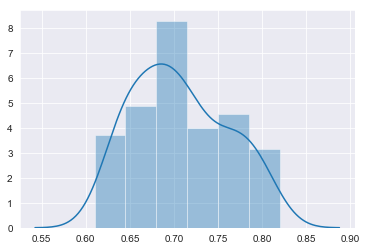

In [9]:
res = run_simulation(100, X_1, y_1, 0.20, 'SVM')

print("Average accuracy of prediction: " + str(np.array(res).mean()))

sns.distplot(res)

# Neural Network 100 simulation Result

Average accuracy of prediction: 0.6798000000000001


100

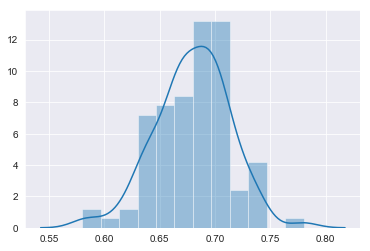

In [10]:
res = run_simulation(100, X_1, y_1, 0.20, 'Neural Network')

print("Average accuracy of prediction: " + str(np.array(res).mean()))

sns.distplot(res)
len(res)

# Random Forest 100 simulation Result

Average accuracy of prediction: 0.611


100

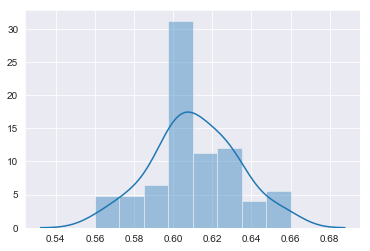

In [11]:
res = run_simulation(100, X_1, y_1, 0.20, 'Random Forest')

print("Average accuracy of prediction: " + str(np.array(res).mean()))

sns.distplot(res)
len(res)

# Bayesian Logistic Classification

Performed using normal approximation for MAP parameter estimation. Theory and posterior density specification/simulation is referenced from *Bayesian Data Analysis 3ed* (Gelman et. al, 2014, pgs 410-411).

In [24]:
import pandas as pd
import numpy as np
import scipy.stats as stats

df = pd.read_csv('/home/ajkappes/temp/stock_ml_df.csv')

df[df['3_category'] == -1] = 0

train_length = int(len(df) * 0.2)
df_idx = df.index.tolist()
train_df = df.loc[df_idx[:-train_length], :]
test_df = df.loc[[idx for idx in df.index.tolist() if idx not in train_df.index.tolist()], :]

features = ['adjusted_gt_index_lag1',  'adjusted_gt_index_lag2', 'adjusted_gt_index_lag3', 'adjusted_gt_index_lag4',
            'standarized_weekly_volume', 'standarized_weekly_volume_lag1', 'standarized_weekly_volume_lag2',
            'standarized_weekly_volume_lag3']
label = ['3_category']

y_train = np.array(train_df[label])
x_train = np.concatenate([np.ones(len(y_train)).reshape(len(y_train), 1), np.array(train_df[features])], axis=1)
y_test = np.array(test_df[label])
x_test = np.concatenate([np.ones(len(y_test)).reshape(len(y_test), 1), np.array(test_df[features])], axis=1)

# Pseudodata for normal approximation MAP estimation (Gelman et al., Bayesian Data Analysis 3ed, 2014, pg 410-411)

def eta_hat(x, b):
    return float(np.asmatrix(x) * b)

def b_hat(x, y):
    x = np.asmatrix(x)
    y = np.asmatrix(y).T
    return np.linalg.inv(x.T * x) * x.T * y

n = len(y_train)
k = x_train.shape[1]
grid = 100
beta_init = .01
beta_dist = [np.matrix([np.repeat(beta_init, k)])]

for j in range(grid):

    pseu_z = []
    for i in range(n):
        eta = eta_hat(x_train[i], beta_dist[j].T)
        y = y_train[i]
        z = eta + (1 + np.exp(eta)) ** 2 / np.exp(eta) * (y / n - np.exp(eta) / (1 + np.exp(eta)))
        pseu_z.append(z[0])

    beta_dist.append(b_hat(x_train, pseu_z).T)

beta_density = np.empty((grid + 1, k))
for j in range(k):
    for i in range(len(beta_dist)):
        beta_density[i, j] = beta_dist[i][0, j]

# MAP estimation for betas

beta_map = np.asmatrix(np.empty((k, 1)))
for j in range(k):
    beta_map[j] = float(stats.mode(beta_density[:, j])[0])

# classification on test data

def classify(x, b):
    threshold = 0.5
    predict = 1 / (1 + np.exp(-(np.matrix(x) * b)))
    return np.where(predict >= threshold, 1, 0)

counts_0 = 0
counts_1 = 0
for i in range(len(y_test)):
    if y_test[i] == 0 and classify(x_train, beta_map)[i] == 0:
        counts_0 += 1

    elif y_test[i] == 1 and classify(x_train, beta_map)[i] == 1:
        counts_1 += 1

    else:
        pass

def get_accuracy(counts, n):
    return counts / n

counts_list = [counts_0, counts_1]
rates = []
for i in counts_list:
    rates.append(get_accuracy(i, len(y_test)))

print('Classiciation rate for 0s:', round(rates[0], 3))
print('Classiciation rate for 1s:', round(rates[1], 3))

Classiciation rate for 0s: 0.877
Classiciation rate for 1s: 0.0
